<a href="https://colab.research.google.com/github/AKugeleviciute/DeepLearning/blob/main/individual_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task**:

*   Create image segmentation model to classify pixels to 3 or more classes
*   Calculate accuracy, precision, recovery and F1 statistics for selected classes on unseen 100 images from OpenImages

**Specifications**:
*   Model used: EfficientNet (efficientnet_b0)
*   Selected classes: *Elephant*, *Fox*, *Polar bear*

**Main resources used for implementation**:

*   Lecture materials
*   Bounding Box Prediction from Scratch using PyTorch: https://github.com/vashiegaran/Bounding-Box-Prediction-from-Scratch-using-PyTorch/tree/main
*   How to Use the Segment Anything Model (SAM): https://blog.roboflow.com/how-to-use-segment-anything-model-sam/


**Author**: Aina Kugelevičiūtė





# Image Segmentation Model

In [ ]:
# Install the Open Images dataset downloader
!pip install openimages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.8 MB/s eta 0:00:00


In [ ]:
import os
from openimages.download import download_dataset

## Downloading Data from Open Images by Class

The annotations for each image were stored in individual XML files, which I downloaded along with the images by specifying the `annotation_format` as `pascal`.

In [ ]:
# Define the directory for storing data
data_dir = r"/content/DL/data"

In [ ]:
# Define the sample size and classes:
number_for_samples = 100
classes = ["Elephant", "Fox", "Polar bear"]

In [ ]:
# Create the data directory if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
# Download the dataset
print("Starting the download process...")
download_dataset(data_dir, classes, limit=number_for_samples, annotation_format="pascal")

Starting the download process...


100%|██████████| 100/100 [00:00<00:00, 1871.60it/s]


{'elephant': {'images_dir': '/content/DL/data/elephant/images',
  'annotations_dir': '/content/DL/data/elephant/pascal'},
 'fox': {'images_dir': '/content/DL/data/fox/images',
  'annotations_dir': '/content/DL/data/fox/pascal'},
 'polar bear': {'images_dir': '/content/DL/data/polar bear/images',
  'annotations_dir': '/content/DL/data/polar bear/pascal'}}

In [ ]:
import random
import pandas as pd
import numpy as np

import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage import io

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
# Set up paths
image_path = Path(data_dir)
annotation_path = Path(data_dir)

In [ ]:
# Function to return a list of filenames for a specific file type under a root directory
def file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [ ]:
# Generate a training dataframe from annotations
def generate_training_df (annotation_path):
    annotations = file_list(annotation_path, '.xml')
    annotations_list = []
    for annotation_file in annotations:
        root = ET.parse(annotation_file).getroot()
        annotation = {}
        annotation['filename'] = Path(str(image_path) + '/' + root.find("./object/name").text + '/' + "images" + '/' + root.find("./filename").text)
        annotation['width'] = root.find("./size/width").text
        annotation['height'] = root.find("./size/height").text
        annotation['class'] = root.find("./object/name").text
        annotation['xmin'] = int(root.find("./object/bndbox/xmin").text)
        annotation['ymin'] = int(root.find("./object/bndbox/ymin").text)
        annotation['xmax'] = int(root.find("./object/bndbox/xmax").text)
        annotation['ymax'] = int(root.find("./object/bndbox/ymax").text)
        annotations_list.append(annotation)
    return pd.DataFrame(annotations_list)

## Creating Training `DataFrame`

In [ ]:
# Create the training dataframe
df_training  = generate_training_df(annotation_path)

In [ ]:
# Map class names to indices
class_dict = {'elephant': 0, 'fox': 1, 'polar bear': 2}
df_training['class'] = df_training['class'].apply(lambda x:  class_dict[x])

In [ ]:
print(df_training.shape)
df_training.head()

(300, 8)


filename width height  class  xmin  \
0  /content/DL/data/fox/images/145de9b828a964f9.jpg  1024   1024      1    85   
1  /content/DL/data/fox/images/2811feb135328ba1.jpg  1024    678      1   163   
2  /content/DL/data/fox/images/13a31709e8983549.jpg  1024    768      1   123   
3  /content/DL/data/fox/images/36fe456d40bdbf12.jpg  1024    934      1   216   
4  /content/DL/data/fox/images/1b6d227ad90e8cd6.jpg  1024    760      1   342   

   ymin  xmax  ymax  
0   275   244   382  
1   178   954   660  
2   195   704   652  
3   200   408   494  
4    63   756   593

## Resizing Images and Bounding Boxes

As training a computer vision model requires images to be of the same size, we must resize both our images and their associated bounding boxes accordingly.

The process of resizing a bounding box involves the following steps:

*   Convert the bounding box into an image, which is called ***mask***

*   Resize the mask to the required dimensions

*   Extract bounding box coordinates from the resized mask

`NOTE`: As can be seen in the example below, the mask will have 0 for the background and 1 for the area covered by the bounding box.


In [ ]:
# Function to read an image from the given path
def read_image(path):
    return cv2.cvtColor(io.imread(str(path)), cv2.COLOR_BGR2RGB)

In [ ]:
# Function to create a mask for the bounding box of the same shape as the image
def create_mask(bounding_box, image):
    rows, cols, *_ = image.shape
    mask = np.zeros((rows, cols))
    bounding_box = bounding_box.astype(int)
    mask[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]] = 1.
    return mask

In [ ]:
# Function to convert a mask to a bounding box
def mask_to_bounding_box(mask):
    cols, rows = np.nonzero(mask)
    if len(cols) == 0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [ ]:
# Function to create a bounding box array from a row in the training dataframe
def create_bounding_box_array(row):
    return np.array([row[5], row[4], row[7], row[6]])

In [ ]:
# Function to resize an image and its bounding box and write image to a new path
def resize_image_and_bounding_box(read_path, write_path, bounding_box, size):
    image = read_image(read_path)
    resized_image = cv2.resize(image, (int(1.49 * size), size))
    resized_mask = cv2.resize(create_mask(bounding_box, image), (int(1.49 * size), size))
    new_image_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))
    return new_image_path, mask_to_bounding_box(resized_mask)

In [ ]:
# Prepare to store new paths and bounding boxes
new_image_paths = []
new_bounding_boxes = []
resized_images_path = Path(r"/content/DL/data/images_resized")

In [ ]:
# Create the resized images directory if it does not exist
if not os.path.exists(resized_images_path):
    os.makedirs(resized_images_path)

In [ ]:
# Resize images and bounding boxes
for index, row in df_training.iterrows():
    new_image_path, new_bounding_box = resize_image_and_bounding_box(row["filename"], resized_images_path, create_bounding_box_array(row.values), 300)
    new_image_paths.append(new_image_path)
    new_bounding_boxes.append(new_bounding_box)

In [ ]:
# Update dataframe with new paths and bounding boxes
df_training['new_path'] = new_image_paths
df_training['new_bb'] = new_bounding_boxes

### Example: Create mask

In [ ]:
sample_index = 16  # Example index for testing
sample_image = cv2.imread(str(df_training.values[sample_index][0]))
bounding_box = create_bounding_box_array(df_training.values[sample_index])
print(sample_image.shape)

(683, 1024, 3)


In [ ]:
Y = create_mask(bounding_box, sample_image)
mask_to_bounding_box(Y)

array([233.,  81., 553., 594.], dtype=float32)

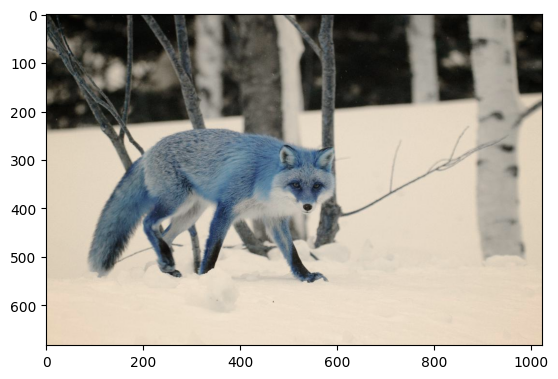

In [ ]:
# Display the original image and its mask
plt.imshow(sample_image)

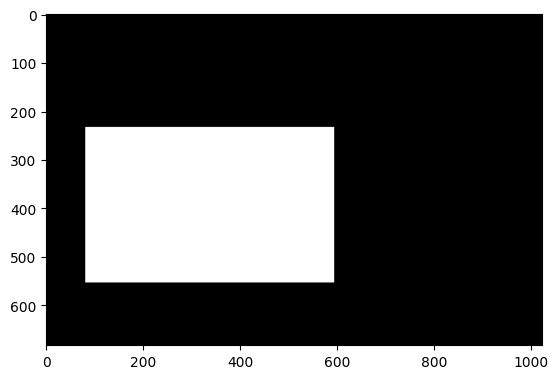

In [ ]:
plt.imshow(Y, cmap='gray')

## Data Augmentation

Since my dataset currently contains only 300 images, I implemented data augmentation to help prevent overfitting in the model. I used various techniques of data augmentation, such as rotation, flip, center crop and random crop.

While performing data augmentation, I ensured that the bounding boxes were transformed in the same manner as the images. To achieve this, I used the same approach I had applied earlier: I converted the bounding boxes into masks and then applied the same transformations to the masks as I did to the original images.

In [ ]:
# Function to crop an image
def crop(image, start_row, start_col, target_rows, target_cols):
    return image[start_row:start_row + target_rows, start_col:start_col + target_cols]

# Function to perform a random crop
def random_crop(image, padding_pixels=8):
    rows, cols, *_ = image.shape
    crop_cols = round(padding_pixels * cols / rows)
    random_row = random.uniform(0, 1)
    random_col = random.uniform(0, 1)
    start_row = np.floor(2 * random_row * padding_pixels).astype(int)
    start_col = np.floor(2 * random_col * crop_cols).astype(int)
    return crop(image, start_row, start_col, rows - 2 * padding_pixels, cols - 2 * crop_cols)

# Function to perform a center crop
def center_crop(image, padding_pixels=8):
    rows, cols, *_ = image.shape
    crop_cols = round(padding_pixels * cols / rows)
    return crop(image, padding_pixels, crop_cols, rows - 2 * padding_pixels, cols - 2 * crop_cols)

In [ ]:
# Function to rotate an image
def rotate_image(image, degrees, is_y=False, border_mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    rows, cols, *_ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), degrees, 1)
    if is_y:
        return cv2.warpAffine(image, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(image, rotation_matrix, (cols, rows), borderMode=border_mode, flags=cv2.WARP_FILL_OUTLIERS + interpolation)

# Function to perform a random crop on the image and mask
def random_crop_with_mask(image, mask, padding_pixels=8):
    rows, cols, *_ = image.shape
    crop_cols = round(padding_pixels * cols / rows)
    random_row = random.uniform(0, 1)
    random_col = random.uniform(0, 1)
    start_row = np.floor(2 * random_row * padding_pixels).astype(int)
    start_col = np.floor(2 * random_col * crop_cols).astype(int)
    cropped_image = crop(image, start_row, start_col, rows - 2 * padding_pixels, cols - 2 * crop_cols)
    cropped_mask = crop(mask, start_row, start_col, rows - 2 * padding_pixels, cols - 2 * crop_cols)
    return cropped_image, cropped_mask

# Function to apply transformations to the image and create a mask
def apply_transformations(image_path, bounding_box, apply_transforms):
    image = cv2.imread(str(image_path)).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255
    mask = create_mask(bounding_box, image)

    if apply_transforms:
        random_degree = (np.random.random() - 0.50) * 20
        image = rotate_image(image, random_degree)
        mask = rotate_image(mask, random_degree, is_y=True)

        if np.random.random() > 0.5:
            image = np.fliplr(image).copy()
            mask = np.fliplr(mask).copy()

        image, mask = random_crop_with_mask(image, mask)
    else:
        image, mask = center_crop(image), center_crop(mask)

    return image, mask_to_bounding_box(mask)

In [ ]:
def create_bounding_box_rectangle(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

# Function to display an image with its bounding box
def display_image_with_bounding_box(image, bounding_box):
    plt.imshow(image)
    plt.gca().add_patch(create_bounding_box_rectangle(bounding_box))

### Example: Transformations

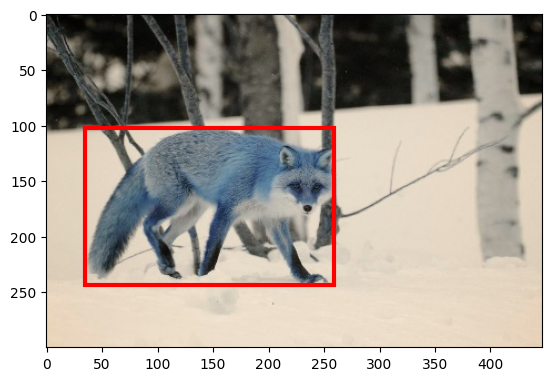

In [ ]:
# Display a sample image with its bounding box
sample_image = cv2.imread(str(df_training.values[sample_index][8]))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
display_image_with_bounding_box(sample_image, df_training.values[sample_index][9])

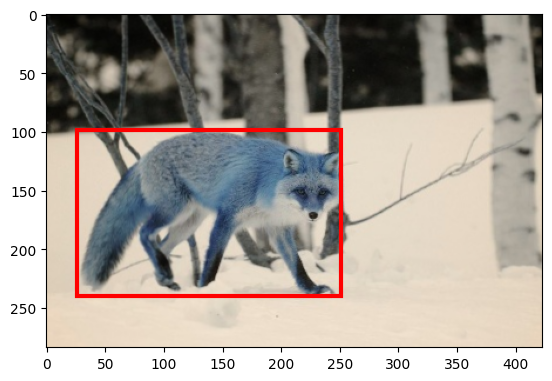

In [ ]:
# Apply transformations to the sample image and display it
transformed_image, transformed_bounding_box = apply_transformations(str(df_training.values[sample_index][8]), df_training.values[sample_index][9], True)
display_image_with_bounding_box(transformed_image, transformed_bounding_box)

## Data Preparation for Training and Validation

In [ ]:
df_training_copy = df_training.copy()

In [ ]:
# Reset the index of the training dataframe
df_training = df_training.reset_index()

In [ ]:
# Prepare features and labels for training
X_data = df_training[['new_path', 'new_bb']]
Y_data = df_training['class']

In [ ]:
total_images = len(X_data)  # Get the total number of images

fixed_val_size = 100

# Calculate the test size as a fraction of the total images
fixed_test_size = fixed_val_size / total_images

In [ ]:
# Split the data into training and validation sets
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(X_data, Y_data, test_size=fixed_test_size, random_state=42)

In [ ]:
print(f"Training dataset size: {len(X_train_data)}")
print(f"Validation dataset size: {len(X_val_data)}")

Training dataset size: 200
Validation dataset size: 100


## Dataset Preparation

In [ ]:
# Function to normalize images
def normalize_image(image):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (image - imagenet_stats[0]) / imagenet_stats[1]

In [ ]:
# Custom dataset class for loading animal images
class AnimalDataset(Dataset):
    def __init__(self, image_paths, bounding_boxes, labels, apply_transforms=False):
        self.apply_transforms = apply_transforms
        self.image_paths = image_paths.values
        self.bounding_boxes = bounding_boxes.values
        self.labels = labels.values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image, bounding_box = apply_transformations(image_path, self.bounding_boxes[idx], self.apply_transforms)
        image = normalize_image(image)
        image = np.rollaxis(image, 2)  # Change from HWC(Height, Width, Channels) to CHW format
        return image, label, bounding_box

## Creating Data Loaders

In [ ]:
# Create training and validation datasets
train_dataset = AnimalDataset(X_train_data['new_path'], X_train_data['new_bb'], y_train_data, apply_transforms=True)
valid_dataset = AnimalDataset(X_val_data['new_path'], X_val_data['new_bb'], y_val_data)

In [ ]:
# Define batch size and create data loaders
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size)

## Model: EfficientNet-Based

In [ ]:
# Define the bounding box prediction model
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()

        # Load the EfficientNet model
        efficient = models.efficientnet_b0(pretrained=True)

        # Freeze the parameters of the EfficientNet model to prevent backpropagation
        for param in efficient.parameters():
            param.requires_grad = False

        # Create a feature extractor by excluding the last classification layer of EfficientNet
        self.features = nn.Sequential(*list(efficient.children())[:-1])

        # Define the classifier for predicting the class labels
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1280), # Normalize the output features
            nn.Flatten(),  # Flatten the tensor for linear layer
            nn.Linear(1280, 3) # Linear layer to output class predictions for 3 classes
        )

        # Define the bounding box regression head to predict the bounding box coordinates
        self.bb = nn.Sequential(
            nn.BatchNorm1d(1280), # Normalize the output features
            nn.Linear(1280, 4)  #Linear layer to output 4 values for bounding box coordinates (x, y, width, height)
        )

    def forward(self, x):
        x = self.features(x)

        # Flatten the output from the feature extractor
        x = x.view(x.shape[0], -1)

        #Get classifier and bounding box predictions
        class_pred = self.classifier(x)   # Class predictions (3 classes)
        bbox_pred = self.bb(x)            # Bounding box predictions (4 values)

        # Apply softmax along the class dimension to get probabilities
        class_prob = F.softmax(class_pred, dim=1)

        return class_prob, bbox_pred

## Training

In [ ]:
# Function to update the learning rate of the optimizer
def update_learning_rate(optimizer, learning_rate):
    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate

In [ ]:
# Function to train the model for a number of epochs
def train_epochs(model, optimizer, train_loader, val_loader, num_epochs=10, normalization_constant=1000):
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_samples = 0
        total_loss = 0

        for x, y_class, y_bb in train_loader:
            batch_size = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            class_output, bb_output = model(x)

            # Compute losses
            class_loss = F.cross_entropy(class_output, y_class, reduction="sum")
            bounding_box_loss = F.l1_loss(bb_output, y_bb, reduction="none").sum(1).sum()
            total_loss_value = class_loss + bounding_box_loss / normalization_constant

            # Backpropagation and optimizer step
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_samples += batch_size
            total_loss += total_loss_value.item()

        train_loss = total_loss / total_samples
        val_loss, val_accuracy = validate_model(model, val_loader, normalization_constant)

        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {val_loss:.4f} \tValidation Accuracy: {val_accuracy:.4f}')

    return total_loss / total_samples

In [ ]:
# Function to evaluate model performance on validation set
def validate_model(model, valid_loader, normalization_constant=1000):
    model.eval()
    total_samples = 0
    total_loss = 0
    correct_predictions = 0

    for x, y_class, y_bb in valid_loader:
        batch_size = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        class_output, bb_output = model(x)

        # Compute losses
        class_loss = F.cross_entropy(class_output, y_class, reduction="sum")
        bounding_box_loss = F.l1_loss(bb_output, y_bb, reduction="none").sum(1).sum()
        total_loss_value = class_loss + bounding_box_loss / normalization_constant

        _, predictions = torch.max(class_output, 1)
        correct_predictions += predictions.eq(y_class).sum().item()
        total_loss += total_loss_value.item()
        total_samples += batch_size

    return total_loss / total_samples, correct_predictions / total_samples

In [ ]:
# Initialize the model and optimizer
model = BB_model().cuda()
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(trainable_parameters, lr=0.006)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


In [ ]:
# Train the model
train_epochs(model, optimizer, train_data_loader, valid_data_loader, num_epochs=15)

Epoch: 1 	Training Loss: 1.5145 	Validation Loss: 1.3227 	Validation Accuracy: 0.9600
Epoch: 2 	Training Loss: 1.3086 	Validation Loss: 1.2615 	Validation Accuracy: 0.9600
Epoch: 3 	Training Loss: 1.2681 	Validation Loss: 1.2234 	Validation Accuracy: 0.9600
Epoch: 4 	Training Loss: 1.2006 	Validation Loss: 1.1767 	Validation Accuracy: 0.9600
Epoch: 5 	Training Loss: 1.1520 	Validation Loss: 1.1047 	Validation Accuracy: 0.9600
Epoch: 6 	Training Loss: 1.0875 	Validation Loss: 1.0253 	Validation Accuracy: 0.9400
Epoch: 7 	Training Loss: 0.9702 	Validation Loss: 0.9421 	Validation Accuracy: 0.9400
Epoch: 8 	Training Loss: 0.8884 	Validation Loss: 0.8743 	Validation Accuracy: 0.9400
Epoch: 9 	Training Loss: 0.8086 	Validation Loss: 0.8389 	Validation Accuracy: 0.9400
Epoch: 10 	Training Loss: 0.7717 	Validation Loss: 0.8360 	Validation Accuracy: 0.9300
Epoch: 11 	Training Loss: 0.7650 	Validation Loss: 0.8269 	Validation Accuracy: 0.9300
Epoch: 12 	Training Loss: 0.7555 	Validation Loss: 0

0.727262659072876

In [ ]:
# Update the learning rate and continue training
update_learning_rate(optimizer, 0.001)
train_epochs(model, optimizer, train_data_loader, valid_data_loader, num_epochs=10)

Epoch: 1 	Training Loss: 0.7149 	Validation Loss: 0.7977 	Validation Accuracy: 0.9500
Epoch: 2 	Training Loss: 0.7245 	Validation Loss: 0.7998 	Validation Accuracy: 0.9500
Epoch: 3 	Training Loss: 0.7250 	Validation Loss: 0.7970 	Validation Accuracy: 0.9500
Epoch: 4 	Training Loss: 0.7193 	Validation Loss: 0.8020 	Validation Accuracy: 0.9500
Epoch: 5 	Training Loss: 0.7144 	Validation Loss: 0.8024 	Validation Accuracy: 0.9500
Epoch: 6 	Training Loss: 0.7175 	Validation Loss: 0.8003 	Validation Accuracy: 0.9500
Epoch: 7 	Training Loss: 0.7152 	Validation Loss: 0.8041 	Validation Accuracy: 0.9500
Epoch: 8 	Training Loss: 0.7145 	Validation Loss: 0.8021 	Validation Accuracy: 0.9500
Epoch: 9 	Training Loss: 0.7218 	Validation Loss: 0.8017 	Validation Accuracy: 0.9400
Epoch: 10 	Training Loss: 0.7159 	Validation Loss: 0.8006 	Validation Accuracy: 0.9400


0.7158765459060669

`NOTE`: I believe that increasing the number of samples and epochs during training could improve the model's accuracy. However, I encountered a couple of challenges along the way. Firstly, I ran into limitations with Google Colab's resources; they aren't unlimited, and there were times when I couldn't access the GPU because Colab restricted me. Secondly, when I ran the code in PyCharm, it took an extremely long time.

## Class Prediction and Bounding Box Estimation

In [ ]:
# Display the validation set
X_val_data.head()

new_path  \
203  /content/DL/data/images_resized/0ded68869e5f6d...   
266  /content/DL/data/images_resized/35c4d73fe329fa...   
152  /content/DL/data/images_resized/22368c7a60fcf6...   
9    /content/DL/data/images_resized/0c0f86df062d0f...   
233  /content/DL/data/images_resized/0e20a5efec6ee1...   

                           new_bb  
203   [191.0, 99.0, 227.0, 151.0]  
266    [24.0, 42.0, 284.0, 421.0]  
152    [16.0, 17.0, 265.0, 211.0]  
9    [132.0, 176.0, 171.0, 254.0]  
233  [118.0, 377.0, 147.0, 433.0]

In [ ]:
# Select a random image from the validation set
test_image_path = X_val_data['new_path'].sample(n=1).iloc[0]
print(test_image_path)

/content/DL/data/images_resized/70719fa332ec3417.jpg


In [ ]:
# Read and resize the test image
test_image = read_image(test_image_path)
test_image = cv2.resize(test_image, (int(1.49 * 300), 300))
cv2.imwrite(test_image_path, cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR))

True

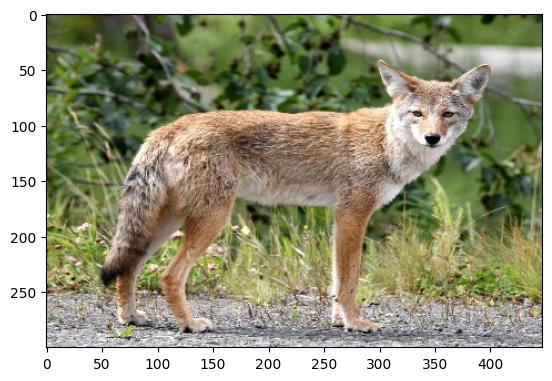

In [ ]:
plt.imshow(test_image)

In [ ]:
# Create a dataset for the test image
test_dataset = AnimalDataset(pd.DataFrame([{'path': test_image_path}])['path'], pd.DataFrame([{'bb': np.array([0, 0, 0, 0])}])['bb'], pd.DataFrame([{'y': [0]}])['y'])
x_test, y_test_class, y_test_bb = test_dataset[0]

In [ ]:
# Prepare the test image for prediction
test_image_tensor = torch.FloatTensor(x_test[None,])
test_image_tensor.shape

torch.Size([1, 3, 284, 423])

In [ ]:
# Get the model's predictions for the test image
output_class, output_bb = model(test_image_tensor.cuda())
output_class, output_bb

(tensor([[1.6700e-06, 9.9995e-01, 5.0971e-05]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor([[ 60.3711,  88.5070, 235.6789, 307.9979]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [ ]:
# Get the predicted class and its probability
predicted_class_index = torch.max(output_class, 1)[1].item()  # Get the index of the max value
predicted_probability = torch.max(output_class, 1)[0].item()  # Get the max value itself

# Format the output string
output_string = "Predicted: {} with probability {:.4f}".format(classes[predicted_class_index], predicted_probability)

print(output_string)

Predicted: Fox with probability 0.9999


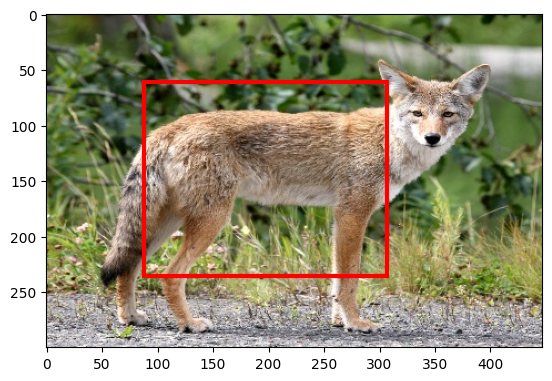

In [ ]:
# Display the predicted bounding box
predicted_bounding_box = output_bb.detach().cpu().numpy()
predicted_bounding_box = predicted_bounding_box.astype(int)
display_image_with_bounding_box(test_image, predicted_bounding_box[0])

## Model Evaluation

In [ ]:
# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred, average='weighted'):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average=average)
    metrics['recall'] = recall_score(y_true, y_pred, average=average)
    metrics['f1_score'] = f1_score(y_true, y_pred, average=average)

    return metrics

In [ ]:
def calculate_iou(bb_true, bb_pred):
    # Unpack the bounding boxes
    x1_true, y1_true, x2_true, y2_true = bb_true
    x1_pred, y1_pred, x2_pred, y2_pred = bb_pred

    # Calculate the coordinates of the intersection rectangle
    x1_inter = max(x1_true, x1_pred)
    y1_inter = max(y1_true, y1_pred)
    x2_inter = min(x2_true, x2_pred)
    y2_inter = min(y2_true, y2_pred)

    # Calculate the area of the intersection rectangle
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Calculate the area of both the prediction and ground truth rectangles
    true_area = (x2_true - x1_true) * (y2_true - y1_true)
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)

    # Calculate the IoU
    iou = inter_area / float(true_area + pred_area - inter_area + 1e-6)  # Add a small epsilon to avoid division by zero

    return iou

In [ ]:
# Function to evaluate the model on the test dataset
def evaluate_model_with_iou(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    iou_scores = []

    with torch.no_grad():
        for x, y_class, y_bb in test_loader:
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda()

            class_output, bb_output = model(x)
            _, predictions = torch.max(class_output, 1)

            y_true.extend(y_class.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

            # Calculate IoU for each sample in the batch
            for true_bb, pred_bb in zip(y_bb.cpu().numpy(), bb_output.cpu().numpy()):
                iou = calculate_iou(true_bb, pred_bb)
                iou_scores.append(iou)

    return np.array(y_true), np.array(y_pred), np.array(iou_scores)

In [ ]:
# Evaluate the model and calculate metrics
y_true, y_pred, iou_scores = evaluate_model_with_iou(model, valid_data_loader)

# Calculate classification metrics
metrics = calculate_metrics(y_true, y_pred)

# Calculate mean IoU
mean_iou = np.mean(iou_scores)

print("Evaluation Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

Evaluation Metrics:
Accuracy: 0.9400
Precision: 0.9451
Recall: 0.9400
F1 Score: 0.9397
Mean IoU: 0.3708


# Segment Anything Model (SAM)

In [ ]:
# To make it easier to manage datasets, images and models create a HOME constant
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
# Install Segment Anything Model (SAM) and other dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.8 MB/s eta 0:00:00


## Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Generate Segmentation with Bounding Box


In [ ]:
mask_predictor = SamPredictor(sam)

### Generate masks with SAM

**NOTE**: `SamPredictor.predict` method takes `np.ndarray` box argument in `[x_min, y_min, x_max, y_max]` format.*italicized text*

In [ ]:
sample_idx = 16
IMAGE_PATH = df_training_copy.loc[sample_index, 'filename']
box = create_bounding_box_array(df_training_copy.values[sample_index])

print(box)

[233  81 554 595]


In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

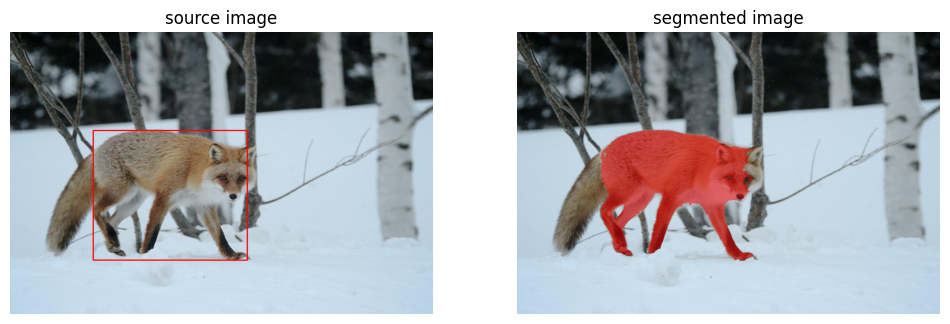

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## SAM Evaluation with IoU

In [ ]:
def calculate_iou_segmentation(pred_mask, true_bounding_box):
    # Create a binary mask from the bounding box
    true_mask = create_mask(true_bounding_box, pred_mask)

    # Calculate intersection and union
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()

    # Calculate IoU
    iou = intersection / union if union > 0 else 0
    return iou

In [ ]:
ious = []
for idx in range(len(X_val_data)):
    # Get the image and corresponding bounding box
    image_path = X_val_data.values[idx][0]
    row = X_val_data.values[idx]
    true_class = y_val_data.values[idx]

    # Read the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Set the image in SAM predictor
    mask_predictor.set_image(image_rgb)

    # Predict masks using SAM
    box = X_val_data.values[idx][1]
    masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

    # Assuming you take the mask with the highest score
    if masks.size > 0:
        best_mask = masks[0]  # Take the first mask for simplicity
        iou = calculate_iou_segmentation(best_mask, box)
        ious.append(iou)

mean_iou = np.mean(ious)
print(f'Mean IoU across validation set: {mean_iou:.4f}')

Mean IoU across validation set: 0.0957


# Semantic Segmentation

## Environment Setup

First, download the code and pretrained models

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation mode

Here we load a pretrained segmentation model. Similar to any `PyTorch` model, we can invoke it as a function or inspect the parameters across all layers.

Once loaded, we transfer the model to the GPU. Since we are performing inference rather than training, we set the model to evaluation mode.

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

## Load test data
Now we load and normalize a single test image. Following standard practice, we normalize the image to a scale where the RGB values of a large photo dataset have a mean of zero and a unit standard deviation, based on statistics from the `ImageNet` dataset.

With this normalization, the RGB values will typically fall within the range of approximately `-2.2` to `+2.7.`

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])

pil_image = PIL.Image.open(IMAGE_PATH).convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

## Run the Model

Finally we simply pass the test image to the segmentation model.

The segmentation model is implemented as a function that accepts a dictionary as its input. This is necessary because it requires both the batch image data and the target output segmentation resolution, which we specify as full resolution.

After that, we use the previously-defined visualize_result function to display the segmentation map.

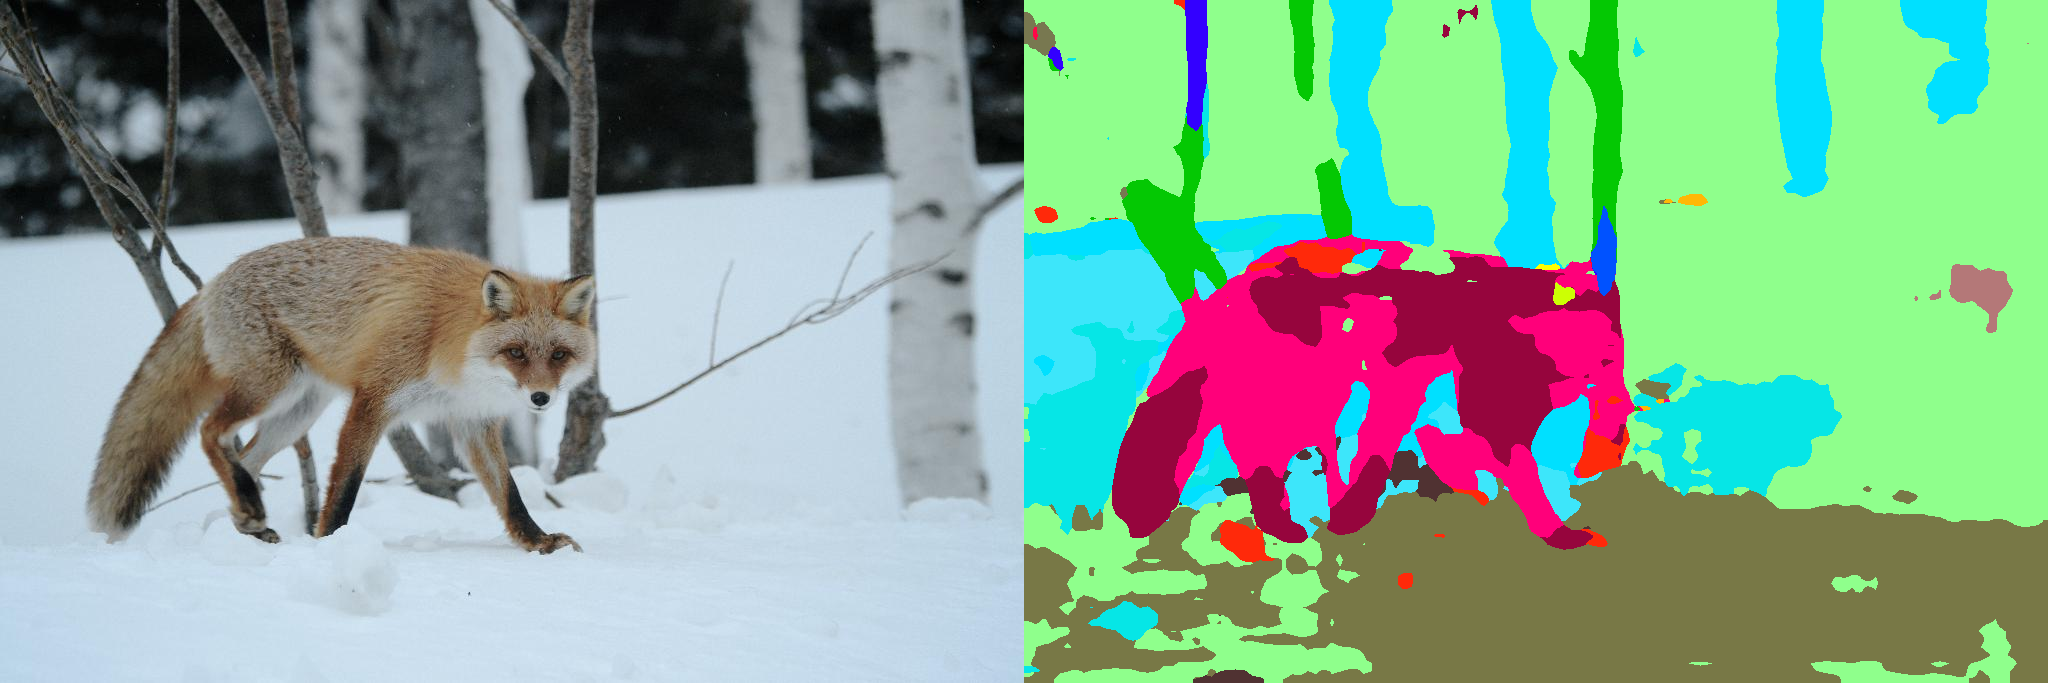

In [ ]:
# Run the segmentation at the highest resolution
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

## Showing selected class

In [ ]:
def find_class_index(class_name):
    for index, name in names.items():
        if class_name.lower() in name.lower():
            return index
    return None

class_name = "animal"
class_index = find_class_index(class_name) - 1

print(class_index)

126


animal:


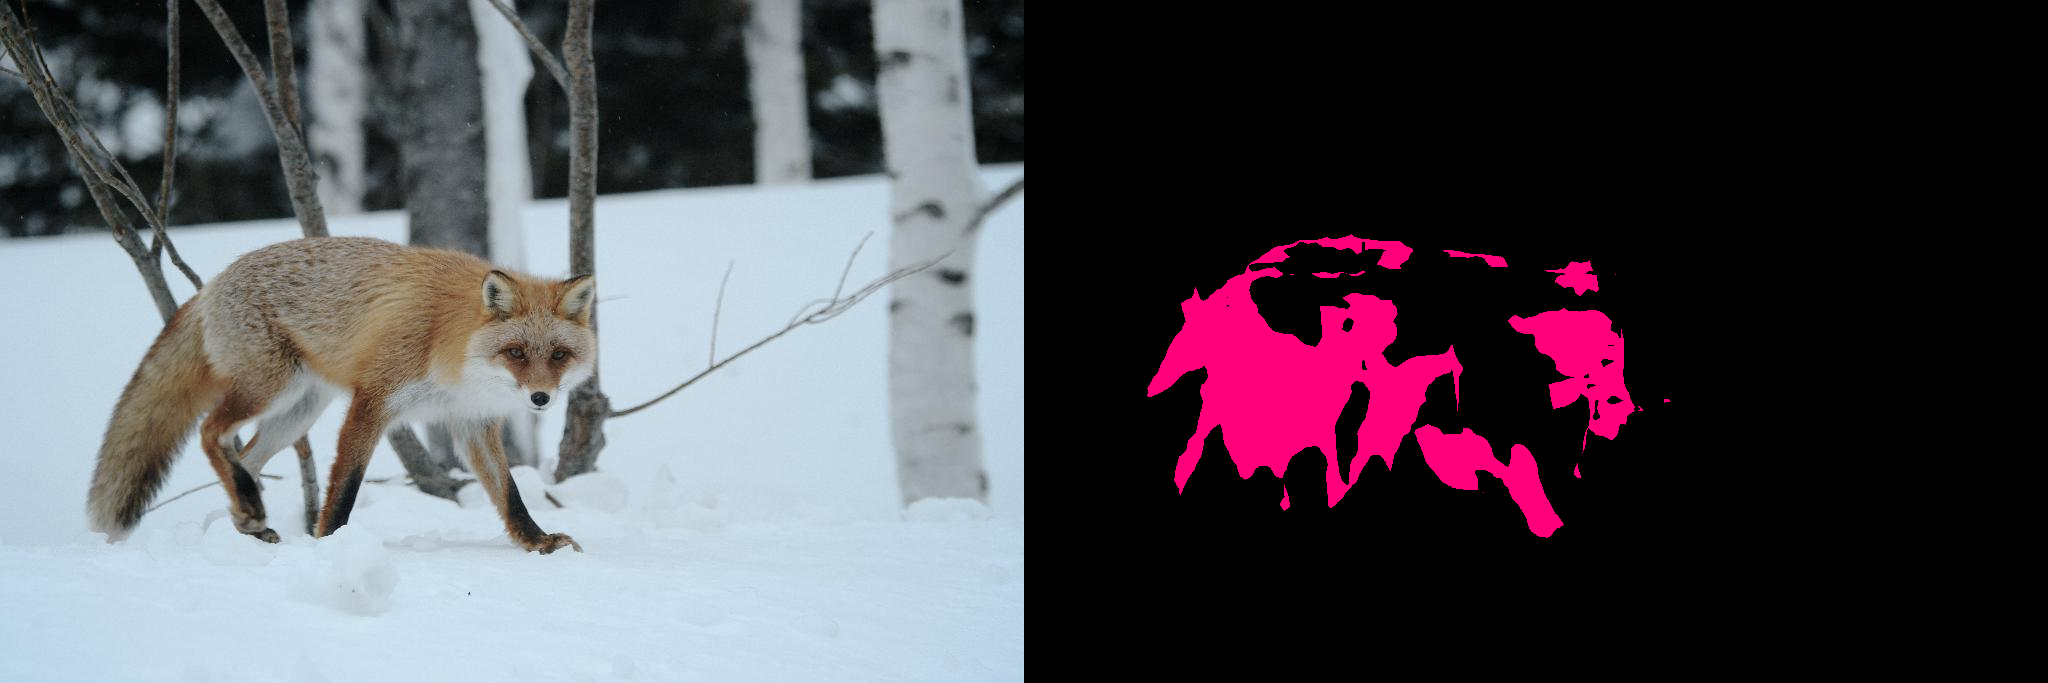

In [ ]:
def visualize_animal_class(img, pred):
        visualize_result(img, pred, class_index)

# Run segmentation and visualize only animal classes
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()

# Visualize only animal class
visualize_animal_class(img_original, pred)

## Segmentation Evaluation with IoU

In [ ]:
ious = []
for idx in range(len(X_val_data)):
    image_path = X_val_data.values[idx][0]
    pil_image = PIL.Image.open(image_path).convert('RGB')
    img_original = np.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    # Run segmentation and visualize only animal classes
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred_mask = (pred > 0.5).cpu().numpy()  # Convert predictions to binary mask

    # Assuming you take the mask with the highest score
    if pred_mask.size > 0:
        best_pred_mask = pred_mask[0]  # Take the first mask for simplicity
        iou = calculate_iou_segmentation(best_pred_mask, box)
        ious.append(iou)

mean_iou = np.mean(ious)
print(f'Mean IoU across validation set: {mean_iou:.4f}')

Mean IoU across validation set: 0.0147
